In [1]:
from imblearn.pipeline import Pipeline
import pickle
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

In [2]:
df = pd.read_csv('../data/Customer-Churn-Records.csv')

In [3]:
# 1. Tentukan kolom kategorikal dan kolom yang akan di-drop
categorical_cols = ['Geography', 'Gender', 'CardType']

# 2. Preprocessor: encoder untuk kategorikal + drop kolom lain
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ],
    remainder='passthrough'  # kolom lain (numerik) dilewatkan begitu saja
)

In [4]:
#Merubah ke numpy.ndarray
y = df['Exited']
X = df.drop(['Exited', 'CustomerId', 'Surname', 'Complain'], axis = 1)

In [5]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [6]:
param = {
    'model__criterion': ['friedman_mse', 'squared_error'],
    'model__learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'model__n_estimators': [50, 100, 150, 200, 250, 300, 350],
    'model__max_depth': [None, 3, 5, 7, 10, 15, 20, 30],
    'model__min_samples_split': [2, 5, 10, 20, 30],
    'model__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', GradientBoostingClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rand_search = RandomizedSearchCV(pipeline, param_distributions=param, cv=cv, scoring='roc_auc', n_jobs=-1)
rand_search.fit(X_train, y_train)

c:\Users\Administrator\anaconda3\envs\myenv\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['Geography',
                                                                                'Gender',
                                                                                'CardType'])])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('model',
                                              GradientBoostingClassifier...
                                        'model__learning_rate': [0.05, 0.1, 0.2,
                                                                 0.3, 0.4, 0.5,
                                                                 0.6, 0.7,
                                                                 0.8],
                                        'model__max_depth': [None, 3, 5, 7, 10,
                                                             15, 20, 30],
                                        'model__max_features': [None, 'sqrt',
                                                                'log2'],
                                        'model__min_samples_leaf': [1, 2, 3, 4,
                                                                    5, 6, 7, 8,
                                                                    9, 10],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20, 30],
                                        'model__n_estimators': [50, 100, 150,
                                                                200, 250, 300,
                                                                350],
                                        'model__subsample': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0]},
                   scoring='roc_auc')

In [7]:
best_pipeline = rand_search.best_estimator_
predict = best_pipeline.predict(X_test)

cmatrix = confusion_matrix(y_test, predict)
acc_score = accuracy_score(y_test, predict)

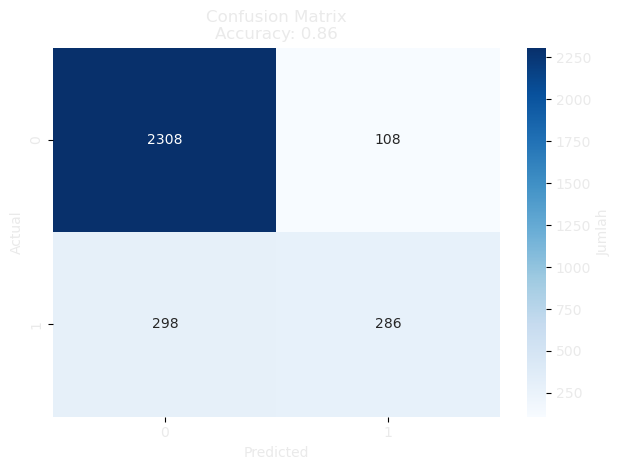

In [8]:
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', linecolor='#eaeaea',)
fig = plt.gcf()
fig.patch.set_facecolor('none')  # transparan

# Judul
plt.title(f'Confusion Matrix\nAccuracy: {acc_score:.2f}', color='#eaeaea')

# Label axis
plt.xlabel('Predicted', color='#eaeaea')
plt.ylabel('Actual', color='#eaeaea')

# Ticks
plt.xticks(color='#eaeaea')
plt.yticks(color='#eaeaea')

# Colorbar
colorbar = plt.gca().collections[0].colorbar
colorbar.set_label('Jumlah', color='#eaeaea')
colorbar.ax.tick_params(labelcolor='#eaeaea')

plt.tight_layout()
plt.show()

In [9]:
classification_gbm = classification_report(y_test, predict)


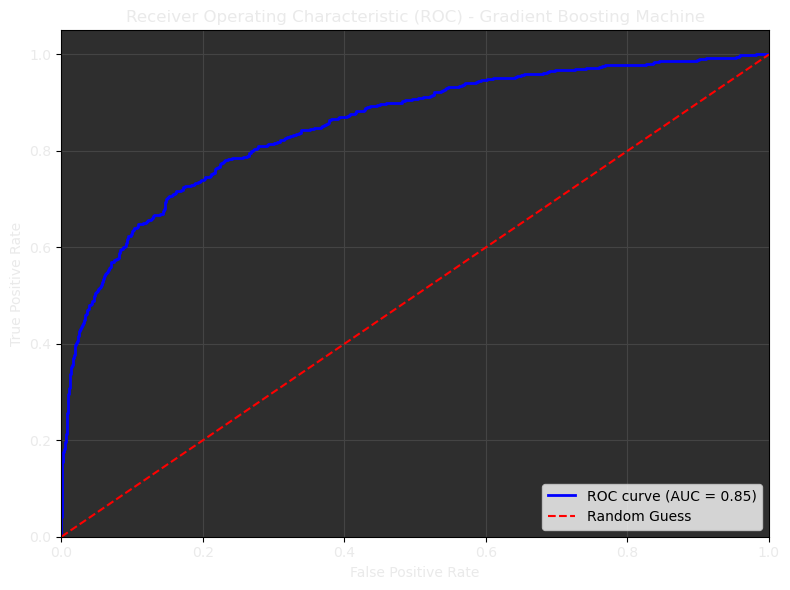

In [10]:
# ROC and AUC for Gradient Boosting
y_pred_proba_gb = best_pipeline.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
roc_auc_score_gb = roc_auc_score(y_test, y_pred_proba_gb)

# Plotting ROC Curve Gradient Boosting Machine
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

fig = plt.gcf()

# Set background color for the figure and axes
fig.patch.set_facecolor('none')  # Transparent background for saving
plt.gca().set_facecolor('#2E2E2E')  # Dark grey or black background for the plot area

# Customize axis labels and title colors for dark mode
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', color='#eaeaea')
plt.ylabel('True Positive Rate', color='#eaeaea')
plt.title('Receiver Operating Characteristic (ROC) - Gradient Boosting Machine', color='#eaeaea')

# Customize ticks color for dark mode
plt.xticks(color='#eaeaea')
plt.yticks(color='#eaeaea')

# Add legend and grid
plt.legend(loc='lower right')
plt.grid(True, color='#444444')  # Light gray grid lines for better visibility

plt.tight_layout()
plt.show()

In [11]:
# Simpan model ke file
with open('../churnapp/churn_model_optimasi.pkl', 'wb') as modelFile:
    pickle.dump(best_pipeline, modelFile)